# Introduction to Classification with Logistic Regression

From the previous week, we established that the neural response to the presentation of stimulus produces a stereotyped pattern of electrical activity on the scalp. This was determined by taking the times when a stimulus was presented and calculating the average EEG activity around that time, i.e. the ERP. We know when the stimuli are presented, so determining how the brain responds to the ERP is fairly straight forward. What is not straight forward is going back the other direction: given the neural activity can be determine whether a stimulus was presented? This is the essential problem of BCI, and the one we will solve. And solving it for this case unlocks a host of new possibilities that, while analytically the same problem, are qualitatively different. It opens up the possibility to decode the identity of the presented stimulus, or a subject's intended action. This is as close to mind-reading as one can get. Let's get to work.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


## Extraction of ERP feature
As a starting point, we will use the data set we worked with last week. An auditory cue was given about every 8 seconds, and there was a robust ERP elicited over occipital and parietal EEG sites. We will select those epochs when we know a cue was presented, and an equal number of epochs where we know a cue was not delivered. To start, we need to load the data.

In [2]:
load_dir = os.path.join(*['..', 'Week3', 'data', 'ds003690'])
subj = 'AB58'
# read chan tsv file


chans = pd.read_csv(os.path.join(load_dir, subj + '_chans.tsv'), sep='\t', index_col='idx')
data = np.load(os.path.join(load_dir, subj + '_data.npy'))
srate = np.load(os.path.join(load_dir, subj + '_srate.npy'))
blinks = np.load(os.path.join(load_dir, subj + '_blinks.npy'))
cues = np.load(os.path.join(load_dir, subj + '_cues.npy'))

with open(os.path.join(load_dir, subj + '_eeg.pkl'), 'rb') as f:
    eeg = pickle.load(f)

AttributeError: Can't get attribute 'EEG' on <module '__main__'>

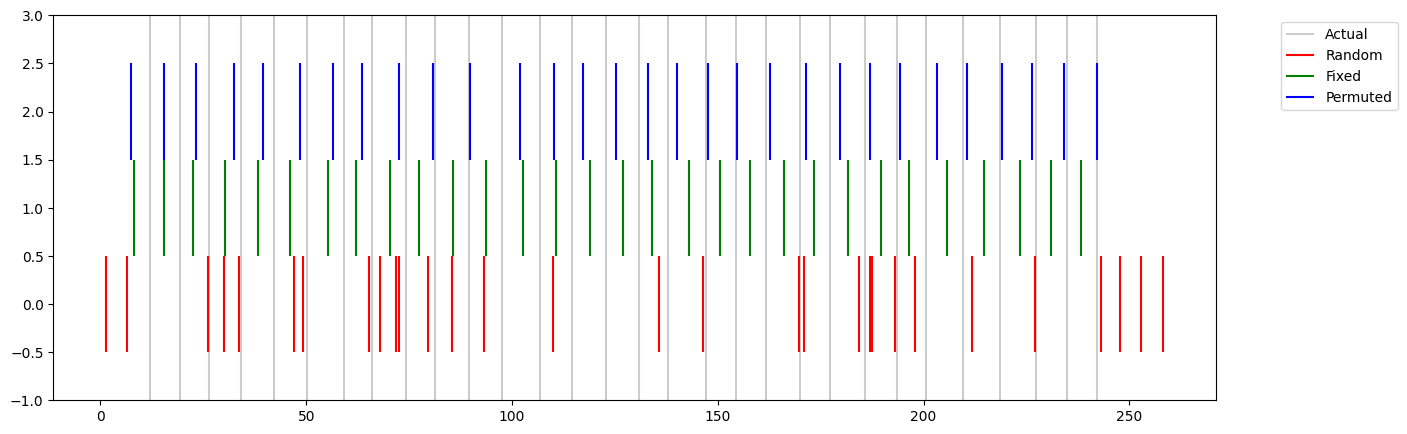

In [ ]:
# set random seed
np.random.seed(47)

## DIFFERENT WAYS TO GET NO CUE PERIODS
no_blinks = lambda c,b: [cue for cue in c if not any(np.abs(cue-b) < 0.6)]
cues_no_blinks = no_blinks(cues, blinks)

# random times between 0 and recording duration
rec_dur = data.shape[1]/srate
cue_num = len(cues)
nocues_rand = np.random.uniform(0, rec_dur, cue_num)

# fixed time before cue method
# fixed time should be less than the shortest iti minus the window.
fixed_time = 4 # half of the mean ITI
nocues_fixed = cues-fixed_time

# randomly shuffle the iti_times
iti_times = np.insert(np.diff(cues), 0, cues[0])
iti_times = np.random.permutation(iti_times)
nocues_perm = np.cumsum(iti_times)

# events plot of the different nocue times and cue times
plt.figure(figsize=(15, 5))
plt.vlines(cues, colors='k', ymin=-1, ymax=3, alpha=0.2)
plt.eventplot([nocues_rand, nocues_fixed, nocues_perm], colors=['r', 'g', 'b'])
plt.ylim(-1, 3)
# plot legend outside axes
plt.legend(['Actual', 'Random', 'Fixed', 'Permuted'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Random no cues without blinks: 87%
Fixed no cues without blinks: 97%
Permuted no cues without blinks: 87%
Random no cues without cue period: 100%
Fixed no cues without cue period: 100%
Permuted no cues without cue period: 96%


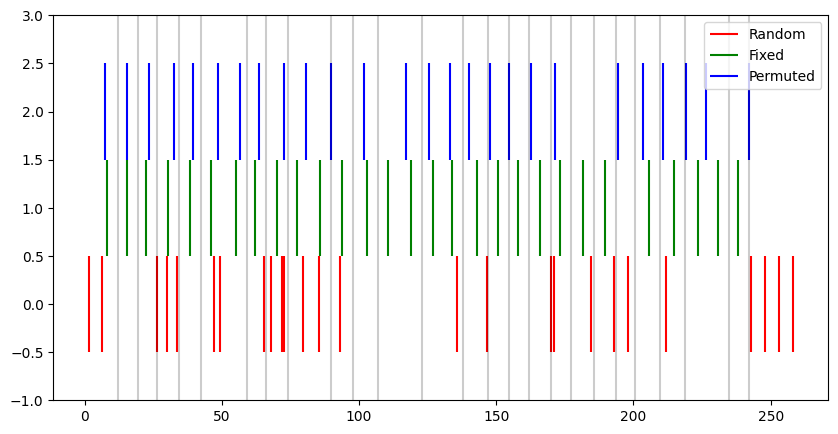

In [ ]:
# create no blink versions
no_blinks = lambda c,b: np.array([cue for cue in c if not any(np.abs(cue-b) < 0.6)])
cues_nob = no_blinks(cues, blinks)

# create no blink versions
nocues_rand_nob = no_blinks(nocue_rand, blinks)
nocues_fixed_nob = no_blinks(nocue_fixed, blinks)
nocues_perm_nob = no_blinks(nocue_perm, blinks)

# print the percent nocues removed by blinks
print('Random no cues without blinks: {:.0f}%'.format(100*(len(nocues_rand_nob)/len(nocues_rand))))
print('Fixed no cues without blinks: {:.0f}%'.format(100*(len(nocues_fixed_nob)/len(nocues_fixed))))
print('Permuted no cues without blinks: {:.0f}%'.format(100*(len(nocues_perm_nob)/len(nocues_perm))))

# plot the no blink versions
plt.figure(figsize=(10,5))
plt.eventplot([nocues_rand_nob, nocues_fixed_nob, nocues_perm_nob], colors=['r','g','b'])
plt.vlines(cues_nob, ymin=-1, ymax=3, color='k', alpha=0.2)
plt.ylim(-1,3)
plt.legend(['Random', 'Fixed', 'Permuted'])

# create verions outside cue period
no_cues = lambda nc,c: np.array([nocue for nocue in nc if not any(np.abs(nocue-c) < 0.01)])

# create versions outside cue period
nocues_rand_noc = no_cues(nocues_rand_nob, cues_nob)
nocues_fixed_noc = no_cues(nocues_fixed_nob, cues_nob)
nocues_perm_noc = no_cues(nocues_perm_nob, cues_nob)

# print the percent nocues removed by blinks
print('Random no cues without cue period: {:.0f}%'.format(100*(len(nocues_rand_noc)/len(nocues_rand_nob))))
print('Fixed no cues without cue period: {:.0f}%'.format(100*(len(nocues_fixed_noc)/len(nocues_fixed_nob))))
print('Permuted no cues without cue period: {:.0f}%'.format(100*(len(nocues_perm_noc)/len(nocues_perm_nob))))




In [ ]:
cue_epochs[:,1:3,:].shape

(300, 2, 25)

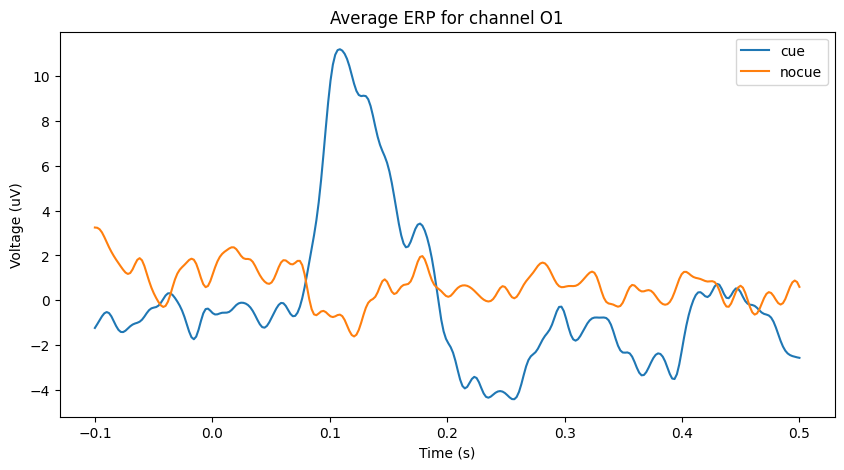

In [ ]:
# let's use the fixed nocue list
pre_window = 0.1 
post_window = 0.5 
epoch_dur = int((pre_window + post_window) * srate)

# first get the cue epochs
cue_starts = ((cues_nob - 0.1) * srate).astype(int)
cue_num = cue_starts.size

cue_epochs = np.zeros((epoch_dur, data.shape[0], cue_num))
for idx, c in enumerate(cue_starts):
    cue_epochs[:,:,idx] = data[:, c:(c + epoch_dur)].T

# next get the nocue epochs
nocue_starts = ((nocues_fixed_noc + 0.1) * srate).astype(int)
nocue_num = nocue_starts.size

nocue_epochs = np.zeros((epoch_dur, data.shape[0], nocue_num))
for idx, c in enumerate(nocue_starts):
    nocue_epochs[:,:,idx] = data[:, c:(c + epoch_dur)].T

# now let's plot the average ERP for each condition on channel O1, where ERP was the strongest
sel_chan = 'O1'
sel_chan_idx = chans.index.values[chans['name'] == sel_chan][0]

# get the average ERP for each condition
cue_erp = np.mean(cue_epochs[:, sel_chan_idx, :], axis=1)
nocue_erp = np.mean(nocue_epochs[:, sel_chan_idx, :], axis=1)
t_erp = np.linspace(-pre_window, post_window, epoch_dur)

# plot the ERPs
plt.figure(figsize=(10, 5))
plt.plot(t_erp, cue_erp, label='cue')
plt.plot(t_erp, nocue_erp, label='nocue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Average ERP for channel ' + sel_chan)
plt.legend()
plt.show()



### Voltage one at peak time




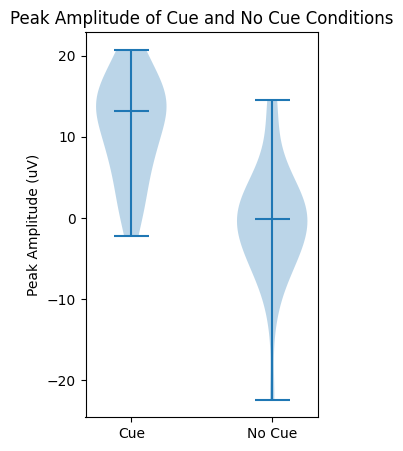

In [ ]:
# get peak idx of cue erp
cue_peak_idx = np.argmax(cue_erp)
cue_peak_idx

cue_erp_peaks = cue_epochs[cue_peak_idx, sel_chan_idx, :].squeeze()
nocue_erp_peaks = nocue_epochs[cue_peak_idx, sel_chan_idx, :].squeeze()

# box plot of peak values for cue and nocue conditions with event plot of points on top
plt.figure(figsize=(3, 5))
plt.violinplot([cue_erp_peaks, nocue_erp_peaks], showmedians=True)
plt.xticks([1, 2], ['Cue', 'No Cue'])
plt.ylabel('Peak Amplitude (uV)')
plt.title('Peak Amplitude of Cue and No Cue Conditions')
plt.show()

### Dot product of ERP

In [ ]:
def dot(x, y):
    """
    Calculate the dot product of two vectors x and y
    """

    out = 0
    for x_i, y_i in zip(x, y):
        out += x_i * y_i

    return out

v1 = [1, 2, 3]
v2 = [2, 2, 2]
print('Dot product of {} and {} = {}'.format(v1,v2,dot(v1, v2)))

v1 = [1, 2, -3]
v2 = [2, 2, 2]
print('Dot product of {} and {} = {}'.format(v1,v2,dot(v1, v2)))

v1 = [1, 2, 3]
v2 = [-2, -2, -2]
print('Dot product of {} and {} = {}'.format(v1,v2,dot(v1, v2)))

Dot product of [1, 2, 3] and [2, 2, 2] = 12
Dot product of [1, 2, -3] and [2, 2, 2] = 0
Dot product of [1, 2, 3] and [-2, -2, -2] = -12


We will use the numpy array dot function, `dot`, because it handles multidimensional dot products well. We want to get the dot product or each trial

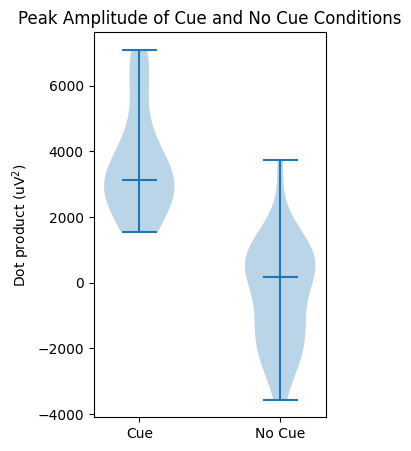

In [ ]:
# DOT PRODUCT ON ENTIRE ERP PERIOD WE SAMPLED
cue_erps = cue_epochs[:, sel_chan_idx, :]
nocue_erps = nocue_epochs[:, sel_chan_idx, :]

def erp_conv(epochs, erp):
    return np.dot(epochs.T, erp)

cue_erp_dot = erp_conv(cue_erps, cue_erp)
nocue_erp_dot = erp_conv(nocue_erps, cue_erp)

# box plot of peak values for cue and nocue conditions with event plot of points on top
plt.figure(figsize=(3, 5))
plt.violinplot([cue_erp_dot, nocue_erp_dot], showmedians=True)
plt.xticks([1, 2], ['Cue', 'No Cue'])
plt.ylabel('Dot product (uV$^2$)')
plt.title('Peak Amplitude of Cue and No Cue Conditions')
plt.show()

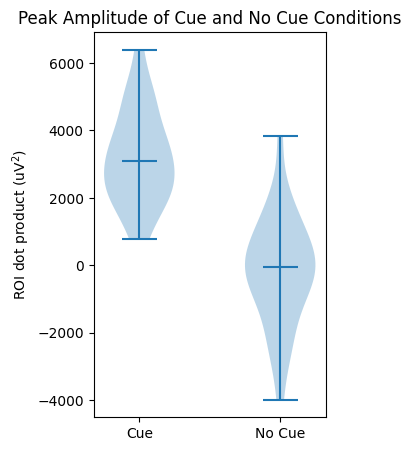

In [ ]:
# DOT PRODUCT ON ROI
cue_erps = cue_epochs[:, sel_chan_idx, :]
nocue_erps = nocue_epochs[:, sel_chan_idx, :]
roi_idxs = (t_erp > 0.08) & (t_erp < 0.3)
def erp_conv(epochs, erp):
    return np.dot(epochs.T, erp)

cue_erp_rdot = erp_conv(cue_erps[roi_idxs,:], cue_erp[roi_idxs])
nocue_erp_rdot = erp_conv(nocue_erps[roi_idxs,:], cue_erp[roi_idxs])

# box plot of peak values for cue and nocue conditions with event plot of points on top
plt.figure(figsize=(3, 5))
plt.violinplot([cue_erp_rdot, nocue_erp_rdot], showmedians=True)
plt.xticks([1, 2], ['Cue', 'No Cue'])
plt.ylabel('ROI dot product (uV$^2$)')
plt.title('Peak Amplitude of Cue and No Cue Conditions')
plt.show()

## A simple decision model
DECISION THRESHOLD

$$ f(x,t) = \left \{
\begin{array}{ll}
    0 & x\leq t \\
    1 & x\gt t \\
\end{array}
\right.    
$$

ACCURACY
ERROR RATE 
$$ Error Rate = \frac{1}{n}\sum_{i=1}^{n}{I(y_{i}\ne \hat{y_{i}})} $$

$$ Accuracy = 1 - Error Rate $$

In [ ]:
# define error rate method with base python
def error_rate_base(y_true, y_pred):
    er = 0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            er += 1
    return 100 * er / len(y_true)

# define error rate method with numpy
def error_rate(y_true, y_pred):
    return np.mean(y_true != y_pred) * 100

# define accuracy method with numpy
def accuracy(y_true, y_pred):
    return 100-error_rate_np(y_true, y_pred)

In [ ]:
# evaluate error rate for ERP peak
# 1 for cue trials, 0 for non-cue trials
class_true = np.repeat([1, 0], [cue_num, nocue_num])
var_peaks = np.append(cue_erp_peaks, nocue_erp_peaks)
dec_thresh = 5
class_pred_peaks = var_peaks > dec_thresh
ac_peak = accuracy(class_true, class_pred_peaks)

print('Accuracy for ERP peaks: {:.1f}%'.format(ac_peak))

Accuracy for ERP peaks: 81.5%


In [ ]:
# evaluate error rate for ERP peaks
# 1 for cue trials, 0 for non-cue trials
var_dot = np.append(cue_erp_dot, nocue_erp_dot)
dec_thresh = 1900
class_pred_dot = var_dot > dec_thresh
ac_dot = accuracy(class_true, class_pred_dot)

print('Accuracy for ERP dot product: {:.1f}%'.format(ac_dot))

Accuracy for ERP dot product: 92.6%


In [ ]:
# evaluate error rate for ERP peaks
# 1 for cue trials, 0 for non-cue trials
var_rdot = np.append(cue_erp_rdot, nocue_erp_rdot)
dec_thresh = 1700
class_pred_rdot = var_rdot > dec_thresh
ac_rdot = accuracy(class_true, class_pred_rdot)

print('Accuracy for ERP ROI dot product: {:.1f}%'.format(ac_rdot))

Accuracy for ERP ROI dot product: 88.9%


We have several different measures of the neural response, and could set different thresholds for our decision to classify a trial as one with a cue or not. But, how do we know we have chosen the best measure and the best threshold? Moreover, can we ascertain how confident our classifier is in the choice it puts out? To address these issue, we need to formalize the classification process. One approach is to use *logistic regression*, which takes a measurement (e.g. ERP peak voltage) and returns the *probability* that it was generated by class (e.g. cue stimulus). For this week, we will pose the problem and learn how to use the logistic regression functions in the scikit-learn package. 

## Binary classification 
A binary classifier takes a set of measurements as inputs $x$ and returns the probability that they were generated by a specific class, $\hat{y}$. (This is known as the *discriminative view* of classification. We will make of the *generative view* later in the semester when we tackle Naive Bayes classifiers.) To get from $x$ to $\hat{y}$, we need a function that describes the *probability* of the class occuring over a range of measurement values.

### A quick probability primer
Probabiltilies describe how likely events are to occur. They range from 0, for events that never happen, to 1, for events that are guaranteed to happen. When quantifying probabilities we do this for a class of events, with the total probability across all events adding up to 1 (which means that at any time one of them has to occur). For instance, in the case of flipping a coin, there is a 0.5 (1/2 or 50%) chance that the coin will come up Heads, and 05. that it will be Tails. These are the only possibilities (this is a Platonic coin, so it has no thickness and thus cannot land on its side). A coin flip is a good example of an *unconditional probability*, which is the same regardless of the circumstances. For this, we would write: 

$$\begin{align}
p(H)&=0.5 \\
p(T)&=0.5 \\
\end{align}
$$

which says that the probability of the coin coming up heads, $p(H)$, is 0.5, and the probability of coming up tails, $p(T)$, is 0.5. 

But probabilities can also depend on the situation, such as the probability that you will buy lunch at a certain time. It is more likely that you will purchase lunch at 11:30 AM than at 10:00 AM. This is a *conditional probability*. Conditional probabilities are expressed as $P(Lunch|Time)$, which translates as the probability of going for Lunch, ($Lunch$), is conditional, $|$, on the time, $Time$. For a conditional probability we need to know the time to give the probability that we are going to lunch.

In the case of our ERP decoder, you can say that the probability of a trial having a cue is conditional on the strength of its ERP, p(Cue|ERP). For this, we need an equation that describes how the probability of being a Cue trial varies as a function of ERP strength.

### Logistic function
One equation that is a useful way to express a conditional probability is the *logistic function* (also known as the sigmoid function). It has the form:

$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

Let's code it up and visualize it:

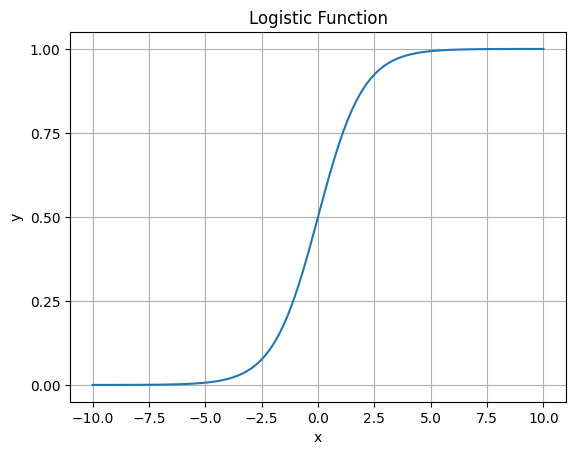

In [ ]:
# create a logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x)) 

# plot the logistic function
x = np.linspace(-10, 10, 100)
plt.plot(x, logistic(x))
plt.title('Logistic Function')
plt.yticks(np.arange(0, 1.1, 0.25))
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

This function is bounded between 0 and 1, just like probabilities. However, by itself it is not useful. It also has a probability of 0.5 when $x=0$, which is not good for us because our decision point, called the *location parameter*, for a cue trial usually had our ERP measure at a positive value.

To shift the location, we can modify x by subtracting the location value from it.

$$ \sigma(x) = \frac{1}{1+e^{-(x-loc)}}$$

How does this look?

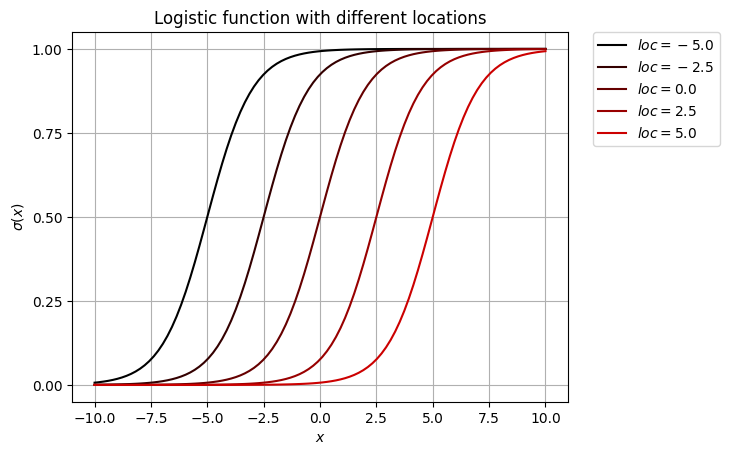

In [ ]:
# create logistic functio with adjustable location
def logistic(x,loc=0):
    return 1/(1+np.exp(-(x-loc))

# plot logistic function with different locations
loc_list = np.arange(-5,6,2.5)
x = np.linspace(-10,10,100)

for ind, loc in enumerate(loc_list):
    plt.plot(x,logistic_mu(x,loc),label='$loc={}$'.format(loc), color=[ind/len(loc_list), 0, 0])

plt.yticks(np.arange(0,1.1,0.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic function with different locations')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


This looks much better, the range of $x$ values overwhich it our logistic function varies, its *scale*, is narrow compared to the range of values we get for our dot product measures of the ERP. This may not seem important now, since a simple classification threshold at 0.5 probability does not care about the spread in our logistic function. But, if we want our function to characterize $p(Cue|ERP)$, then this matters. Adjusting the scale is straightforward with the addition of a new parameter.

$$ \sigma(x)=\frac{1}{1+e^{-\frac{x-loc}{scale}}} $$

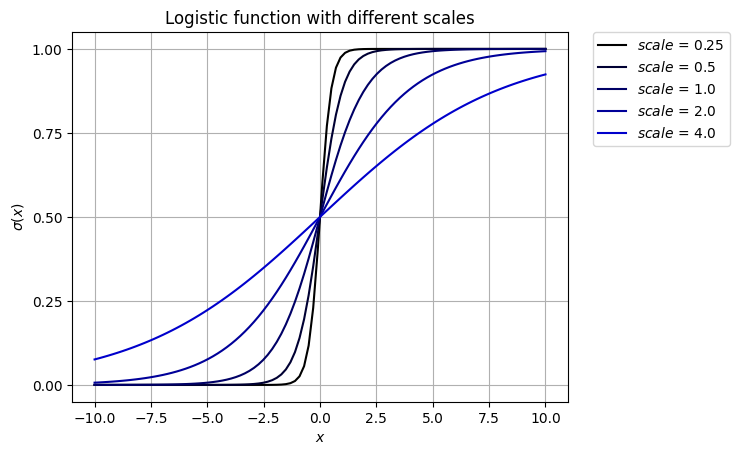

In [ ]:
# logistic function with location and scale parameters
def logistic(x, loc=0, scale=1):
    return 1 / (1 + np.exp(-(x - loc) / scale))

# plot the logistic function
x = np.linspace(-10, 10, 100)
loc = 0
scale_list = np.power(2.0, range(-2, 3, 1))

for ind, scale in enumerate(scale_list):
    plt.plot(x, logistic(x, loc, scale), label='$scale$ = {}'.format(scale), color=[0, 0, ind / len(scale_list)])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.grid()
plt.title('Logistic function with different scales')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Great, we can change the spread of the logistic function now. With these two degrees of freedom, location and scale, we are able to create a function that captures the probability of a certain class (in our case, a cue trial) occuring. An important caveat to this function is that it is monotonic, meaning that the probability of being that class only increases (or decreases) as one increases the value of $x$. This works for most cases, but not if our class occurs for only a restricted range of $x$ values (e.g. between 2 and 5). But don't worry, later we will cover a few tricks that circumvent this limitation.

## Fitting the logistic function
Using the logistic function requires us to choose values for the location and scale parameters, which we *could* try doing by hand. That is not recommended. Instead, we will use the `LogisticRegression` class in the scikit-learn package. This class defines an object that can take our measurements and true classes, fit a logistic function to that data, and then deliver class predictions. To start using this, we will cover how scikit-learn implements its fitting functions in general, and then the specifics of the `LogisticRegression` class.

### Scikit-learn standards
Scikit-learn is a python package started in 2007 and has grown to include a wide variety of machine learning algorithms. Most of these are implemented as *estimators*, which are classes that allow one to fit a model or function to some data and then make predictions from that model. The project has adopted a uniform standard for the creation of estimators, making it easier to incorporate new ones into the project or develop your own that will comprehensible to users already familiar with scikit-learn. For details you can check out the online documentation for developers (https://scikit-learn.org/stable/developers/develop.html).

We will step through these using the `LogisticRegression` class to fit our predictor of of whether a cue was present on a trial given the ERP.

### Initializing
To use the `LogisticRegression` class, we need to create an instance of it as an object. Parameters specifying how to fit the function to your data, using set using the `__init__` method, but also accessible with a `set_params` method after you created the estimator. When no parameters are given to initialize the object. 


In [ ]:
# create a vanila LogisticRegression object
clf = LogisticRegression()

# examine its default fitting parameters
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The only one worth mentioning at this time is `fit_intercept`, which determines if we will include a location parameter in our fitting. By default this is set to True, so we don't have to worry about explicitly setting it.

### Fitting
Now that we have our `LogisticRegression` object, we can call its `fit` method. It accepts arrays containing your indepdentent, $x$, and dependent, $y$ variables and optimizes the function to best fit that data. Fit accepts two inputs. First is `X`, which is an array of measurements. It has 2 dimensions, with each row a different *sample* (e.g. trial), and each column a different *feature* (e.g. ERP peak voltage). Its shape is (n_samples, n_features), where 'n' stands for number. You can have multiple features per sample, which allows us to use more than one aspect of the measured brain activity on a trial to decode whether a stimulus was present.

The next input is `y`, the true class labels (e.g. Cue or NoCue) labels. Its shape is (n_samples,), where n_samples is the same as `X`. Notice that `X` is uppercase and `y` is lowercase. This is because a common notational convention is that a matrix (a 2-D array) is represented by an uppercase character, while vectors (1-D array) use lowercase characters.

In [ ]:
# format X
# concatenate 
X = np.append(cue_erp_peaks, nocue_erp_peaks, axis=0)
# add dimension to X, because X needs to be a 2D array
X = X[:, np.newaxis]
print('The shape of X is {}'.format(X.shape))

# format y
y = np.append(np.ones(cue_erp_peaks.shape[0]), np.zeros(nocue_erp_peaks.shape[0]))
print('The shape of y is {}'.format(y.shape))

# fit the model
clf.fit(X, y)

The shape of X is (54, 1)
The shape of y is (54,)


LogisticRegression()

That's it, we fit the model! A bit anticlimatic, since all we did was update the `clf` object with a fitted model. The next thing we need to do is evaluate the performance of the fitted model.

### Evaluating
There are couple ways to judge the performance of our model. When we implemented our simple thresholded decision model above, we used accuracy as our measure. The `LogisticRegression` class provides a method named `score` that can calculate accuracy. It accepts `X` and `y` parameters similar to the `fit` method. Note: you do not have to provide the same `X` and `y` used for `fit`, but can use new data that the model was not trained on (in fact, this is a better practice as we will discuss later). It returns a number between 0 and 1, with 1 being perfect classification, and 0 being totally incorrect classification. This single number provides a good topline indication of whether the fit was successful. Poor accuracy will usually not be at 0, but at a level consisent with random guessing. For binary decoding with equal numbers of each class, this would be 0.5.

In [ ]:
# calculate the score for our model
score = clf.score(X, y)

print('Accuracy for our model: {:.2f}%'.format(score*100))

Accuracy for our model: 85.19%


The logisitc regression decoder out performs our simple threshold classifier we set by eye, which was 81.5%. Not by much, but better nonetheless. 

We might want to also visualize the logistic function that was fitted. To do this, we can use the `predict_proba` method. This takes samples, not necessarily the ones we fitted on, and returns the probability of either class for each sample. A good strategy here to is take the minimum and maximum values of the features in your dataset, and then create a grid of samples that span their range. This works really well when we have less than 3 features per sample, or in our case just 1 feature. If we plot the predicted probabilities across values of $x$, we can visualize the logistic function.

The shape of pred_probs is: (100, 2)


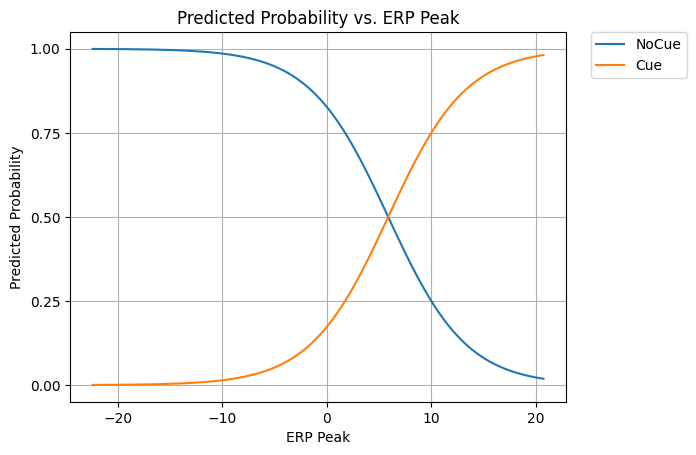

In [ ]:
# create range of feature values
min_erp_peak = np.min(X)
max_erp_peak = np.max(X)
erp_peak_vals = np.linspace(min_erp_peak, max_erp_peak, 100)
erp_peak_vals = erp_peak_vals[:, np.newaxis]

# predict probabilities over range of values
pred_probs = clf.predict_proba(erp_peak_vals)
print('The shape of pred_probs is: {}'.format(pred_probs.shape))

# plot predicted probability of each class
plt.plot(erp_peak_vals, pred_probs[:,0], label='NoCue')
plt.plot(erp_peak_vals, pred_probs[:,1], label='Cue')
plt.xlabel('ERP Peak (uV)')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability vs. ERP Peak')
plt.yticks(np.arange(0,1.1,0.25))
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


Note that `predict_proba` returns a matrix with the same number of rows as the samples we passed in `erp_peak_vals`, and two columns, one for each class (NoCue or Cue). Since we only have two classes, the probabilities of NoCue and Cue will add to 1 for each sample. This makes one of them redundant, so for future plotting we will drop the NoCue one. 

It is helpful to plot our classes with the data points layered on top, which helps us better visualize the performance of the fit and whether it is falling prey to some issues that will be discussed later.

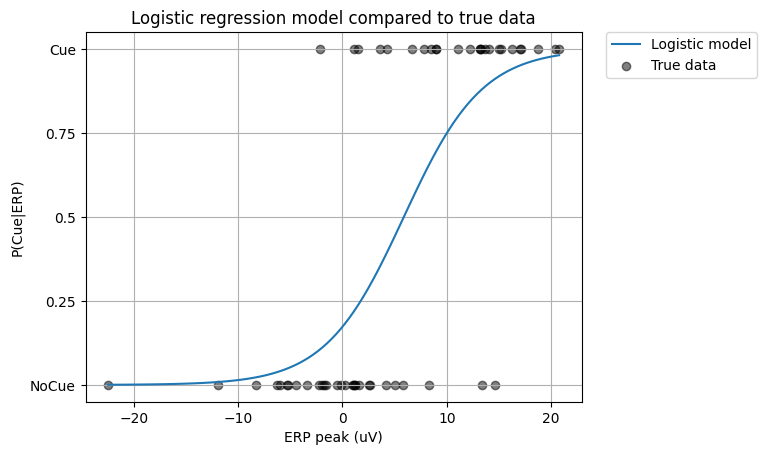

In [ ]:
plt.plot(erp_peak_vals, pred_probs[:,1], label='Logistic model')
plt.scatter(X, y, c='k', alpha=0.5, label='True data')
plt.xlabel('ERP peak (uV)')
plt.ylabel('P(Cue|ERP)')
plt.title('Logistic regression model compared to true data')
plt.yticks(np.arange(0,1.1,0.25))
plt.gca().set_yticklabels(['NoCue', '0.25', '0.5', '0.75', 'Cue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

The logistic function seems to reflect the p(Cue|EPR) quite well. Its probabiity increases strongly after the bulk of the NoCue ERP peaks, and is near 1 when only Cue ERP peak values remain. Instead of describing our logistic fit qualitatively, it would be better to do so quantitatively, using the parameters we discussed before, location and scale. However, here we will have to make things a little more complicated by changing how we parameterize the model. This initial pain is worth it though, because later it will give us far more freedom in how we can use the logistic function.

### Interpreting
The parameters of the logistic function tell us how it asigns a class probability to a measure. When we first introduced it, we used location and scale parameters. These are not used by the `LogisticRegression` class. Instead, it is formulated as:

$$ \sigma(x) = \frac{1}{1+e^{-(b+wx)}} $$

Here $b$ stands for the *bias* or *intercept*, which is similar, but not exactly the same as the location parameter. $w$ is the slope of the dependence on $x$, and is similar, but not exactly the same as the scale parameter.

How do these new parameters affect the logisitic function?


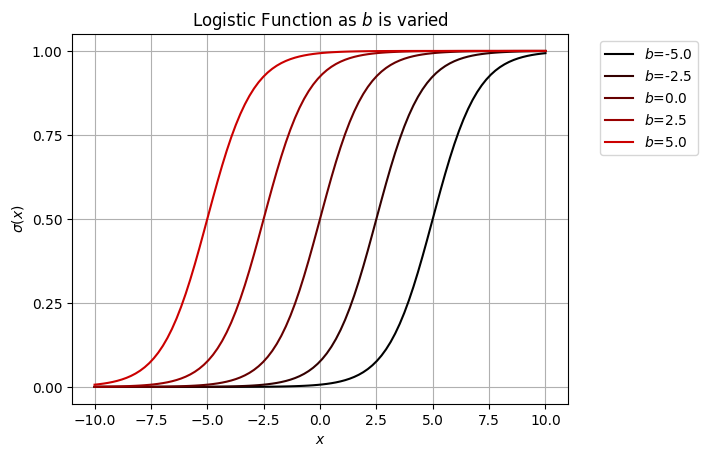

In [ ]:
def logistic(x, b=0, w=1):
    return 1 / (1 + np.exp(-(w * x + b)))

# plot the logistic function as b is varied
x = np.linspace(-10, 10, 100)
b_list = np.arange(-5,6,2.5)
for idx, b in enumerate(b_list):
    plt.plot(x, logistic(x, b=b), label=f'$b$={b}', color=[idx/len(b_list), 0, 0])
#plot legend outside axes
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(np.arange(0,1.1,.25))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $b$ is varied')
plt.grid()
plt.show()

Looks like $b$ has exactly the same effect as location, but what if we vary $w$?

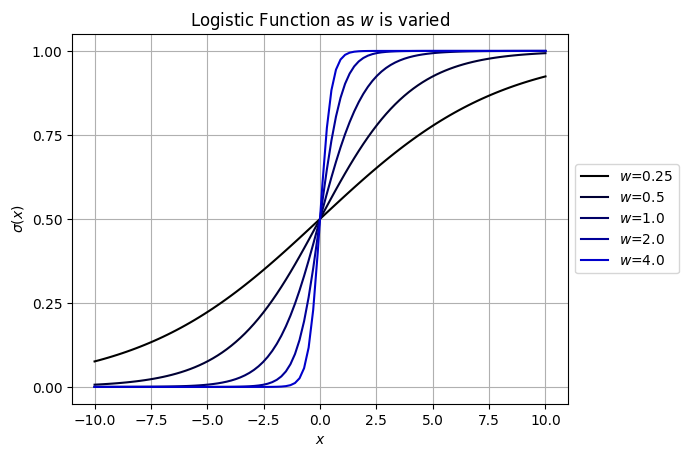

In [ ]:
# plot logistic function as w is varied
w_list = np.power(2.0, np.arange(-2, 3))

for idx, w in enumerate(w_list):
    plt.plot(x, logistic(x, b=0, w=w), label='$w$={}'.format(w), color=[0,0,idx/len(w_list)])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $w$ is varied')
plt.grid()
plt.show()

It may look the same, but look at the colors to the lines. When we increased the scale parameter, the spread of the logistic function decreased. But in this case, increasing the $w$ parameter decreases the spread. And it gets worse, look what happens when $b$ is not set to 0:

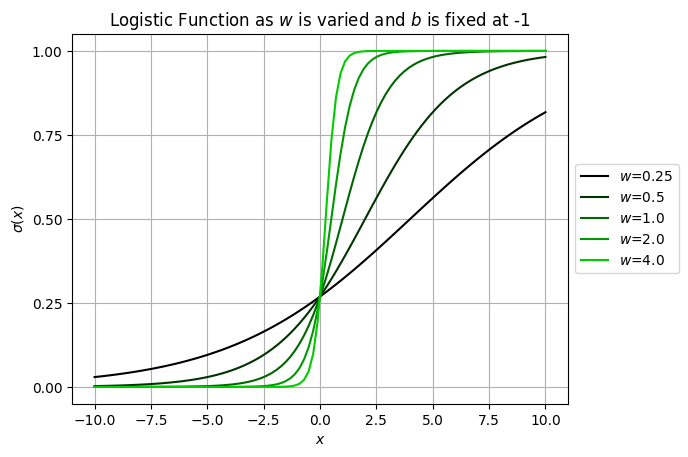

In [ ]:
# plot logistic function as w is varied and b is not zero
new_b = -1
for idx, w in enumerate(w_list):
    plt.plot(x, logistic(x, b= new_b, w=w), label='$w$={}'.format(w), color=[0,idx/len(w_list),0])
plt.yticks(np.arange(0, 1.1, 0.25))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$x$')
plt.ylabel('$\sigma(x)$')
plt.title('Logistic Function as $w$ is varied and $b$ is fixed at {}'.format(new_b))
plt.grid()
plt.show()

When $b$ is not at zero, then changing $w$ affects the location of the logistic function. We can use some simple algebra to resolve these issues.

First, recognize that the loc parameter specifies when the logistic function is equal to 0.5. This happens when $x = 0$:

$$ \begin{align}
        \notag 0.5&=\frac{1}{1+e^{-x}} \\
        \notag 0.5&=\frac{1}{1+e^{-0}} \\
        \notag 0.5&=\frac{1}{1+1} \\
        \notag 0.5&=\frac{1}{2}
    \end{align}
$$

INTRODUCE ALGEBRAIC MANIPULATION TO GET LOCATION
$$ \begin{align}
        \notag 0&=-(b+wx) \\
        \notag 0&=-b-wx \\
        \notag b&=-wx \\
        \notag -\frac{b}{w}&=x
    \end{align}
$$


ADD DESCRIPTION OF DERIVING SCALE PARAMETER

The location parameter is more important to us when interpreting the logistic function because it tells us when the classifier will label an ERP as arising from a Cue. To get that, we need to pull out the $b$ and $w$ parameters from the fitted `LogisticRegression` object.


In [ ]:
# get b, also known as the intercept parameter
b = clf.intercept_
print('The shape of intercept_ is: {}'.format(b.shape))
print('The intercept of our model is {:.2f}'.format(b[0]))

The shape of intercept_ is: (1,)
The intercept of our model is -1.56


`intercept_` is a class variable created once we call the `fit` method. It is a numpy array with a single value. To get $w$, access the `coef_` variable.

In [ ]:
# get w from coef_
w = clf.coef_
print('The shape of coef_ is: {}'.format(w.shape))
print('The value of coef_ is: {:.2f}'.format(w[0,0]))

The shape of coef_ is: (1, 1)
The value of coef_ is: 0.27


Now that we have $b$ and $w$, we can precisely position the decision boundary on for our fitted logistic function.

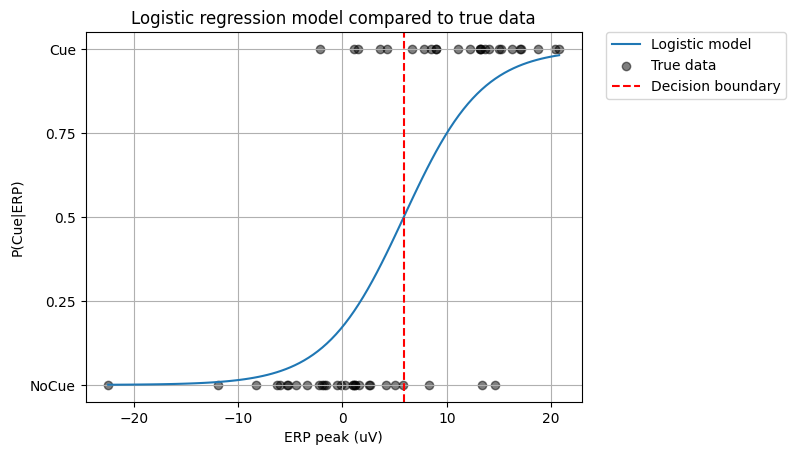

In [ ]:
# calculate the decision boundary
dec_bound = -b[0]/w[0,0]

# plot the decision boundary
plt.plot(erp_peak_vals, pred_probs[:,1], label='Logistic model')
plt.scatter(X, y, c='k', alpha=0.5, label='True data')
plt.xlabel('ERP peak (uV)')
plt.ylabel('P(Cue|ERP)')
plt.title('Logistic regression model compared to true data')
plt.yticks(np.arange(0,1.1,0.25))
plt.gca().set_yticklabels(['NoCue', '0.25', '0.5', '0.75', 'Cue'])
plt.axvline(dec_bound, color='r', linestyle='--', label='Decision boundary')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()

### Prediction
Once the model is fitted, you want to use it to fit new samples. Since we used all our data to fit the model, predicting on the same data would circular. Instead, we can try retraining the model on a subset 

In [ ]:
dir(clf)

## ISSUES WITH FITTING
### UNBALANCED DATASETS
### OVERFITTING

### Bernouli distribution

### Logistic function and Logit tansform

References
G. James et al., An Introduction to Statistical Learning, Springer Texts in Statistics, Chapter 4, https://doi.org/10.1007/978-3-031-38747-0_4
